In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [7]:
import requests
headers = {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36'),  # noqa: E501
    'Dnt': ('1'),
    'Accept-Encoding': ('gzip, deflate, sdch'),
    'Accept-Language': ('en'),
    'origin': ('http://stats.nba.com')
    }


In [8]:
def load_nba_dataset(json_data):
    result_data = json_data['resultSets'][0]
    headers = result_data['headers']
    shots = result_data['rowSet']
    data_frame = pd.DataFrame(data=shots, columns=headers)
    return data_frame

In [9]:
curr_season = "http://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight="
last_season = "http://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2016-17&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight="

In [32]:
curr_season_stats = load_nba_dataset(requests.get(curr_season, headers=headers).json())
last_season_stats = load_nba_dataset(requests.get(last_season, headers=headers).json())

In [33]:
# Filtering minutes per game
curr_season_stats = curr_season_stats.loc[(curr_season_stats.MIN > 15) & (curr_season_stats.GP > 10)]

In [34]:
# Taking first 200 in 3 pointers attempted
curr_season_stats = curr_season_stats.loc[curr_season_stats.FG3A_RANK <= 100]

In [93]:
def get_three_point_pct_diff(current_season, last_season):
    pct_diffs, attempts_diff = [], []
    last_years_pct, last_years_attempts = [], []
    for i in range(len(current_season)):
        curr_series = current_season.iloc[i]
        past_season_player = last_season.loc[last_season.PLAYER_ID == curr_series.PLAYER_ID]
        if curr_series.PLAYER_ID not in past_season_player.PLAYER_ID.tolist():
            pct_diffs.append(0.0)
            attempts_diff.append(0)
            last_years_pct.append(0)
            last_years_attempts.append(0)
            continue
        attempt_difference = curr_series.FG3A - past_season_player.FG3A.iloc[0]
        pct_diff = curr_series.FG3_PCT - past_season_player.FG3_PCT.iloc[0]
        last_years_pct.append(past_season_player.FG3_PCT.iloc[0])
        last_years_attempts.append(past_season_player.FG3A.iloc[0])
        pct_diffs.append(pct_diff)
        attempts_diff.append(attempt_difference)
    current_season['PCT_DIFF'] = pct_diffs
    current_season['ATT_DIFF'] = attempts_diff
    current_season['FG3_PCT_LAST'] = last_years_pct
    current_season['FG3_ATT_LAST'] = last_years_attempts
    return current_season

In [315]:
curr_season_stats = get_three_point_pct_diff(curr_season_stats, last_season_stats)

In [333]:
top_8_improved_shooters = curr_season_stats.sort_values(by="PCT_DIFF", ascending=False).iloc[:8]
top_8_improved_shooters = top_8_improved_shooters.sort_values(by="PCT_DIFF")

In [348]:
player_list = top_8_improved_shooters.PLAYER_NAME.tolist()
last_year_pct = top_8_improved_shooters.FG3_PCT_LAST.tolist()
this_year_pct = top_8_improved_shooters.FG3_PCT.tolist()
last_year_att = [ item * 500 for item in top_8_improved_shooters.FG3_ATT_LAST.tolist()]
this_year_att = [ item * 500 for item in top_8_improved_shooters.FG3A.tolist()]

In [353]:
player_dict = {}
y_list = []
for i in range(len(player_list)):
    y_list.append(i)
    player_dict[i] = player_list[i]

In [355]:
plt.style.use('fivethirtyeight')

[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
[-1.0, u'Victor Oladipo', u'Kelly Oubre Jr.', u'Robert Covington', u'Tobias Harris', u'Taurean Prince', u"E'Twaun Moore", u'Aaron Gordon', u'Al-Farouq Aminu', 8.0]


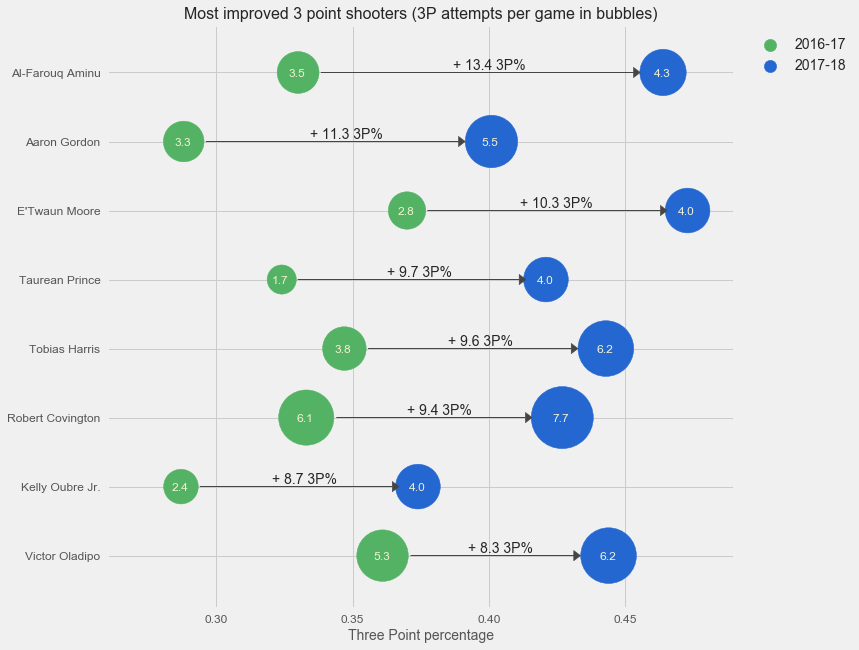

In [369]:
plt.figure(figsize=(10, 10))
dpi = plt.gcf().get_dpi()
plt.scatter(last_year_pct, y_list, color="#53B263", s=last_year_att * 500, label="2016-17")
plt.scatter(this_year_pct, y_list, color="#2467D1", s=this_year_att * 500, label="2017-18")

# plt.hlines(top_8_improved_shooters.PLAYER_NAME, top_8_improved_shooters.FG3_PCT_LAST, top_8_improved_shooters.FG3_PCT, colors=["#415951"])

for i in range(len(top_8_improved_shooters)):
    current = top_8_improved_shooters.iloc[i]

    y = i # current index equals the string index
    plt.text(x=current.FG3_PCT_LAST - 0.0035, y= y-0.05, s=current.FG3_ATT_LAST, color="#F3F1D0", fontsize=12)
    plt.text(x=current.FG3_PCT - 0.0035, y= y-0.05, s=current.FG3A, color="#F3F1D0", fontsize=12)
    
    marker_size = current.FG3_ATT_LAST * 500
    marker_size = marker_size**(0.5) / 2.0
    marker_size /= 2500 # magic
    
    target_marker_size = current.FG3A * 500
    target_marker_size = target_marker_size**(0.5) / 2.0
    target_marker_size /= 2100 # magic

    start_x = current.FG3_PCT_LAST + marker_size
    dx = current.FG3_PCT - start_x - marker_size
    if current.PLAYER_NAME in ["Taurean Prince", "Aaron Gordon", "Tobias Harris"]:
        dx -= 0.0015 # heh, some hardcoding
    arrow = plt.arrow(x=start_x, y= y, dx=dx, dy=0, head_length=0.0025, head_width=0.15, length_includes_head=True, fc='#454545', color='#454545')
    
    plt.text(x=(current.FG3_PCT + current.FG3_PCT_LAST) / 2 - 0.01, y = y+0.05, s="+ " + str(current.PCT_DIFF*100) + " 3P%")
plt.title("Most improved 3 point shooters (3P attempts per game in bubbles)", fontsize=16)
plt.xlabel("Three Point percentage", fontsize=14)
plt.tick_params(axis='both', labelsize=12)

curr_ax = plt.gca()
labels = [item for item in curr_ax.get_yticks()]
for i in range(len(labels)):
    label = labels[i]
    if label == -1.0 or label == 8.0:
        continue
    labels[i] = player_dict[label]

curr_ax.set_yticklabels(labels)

plt.xlim(0.26, 0.49)
legend = plt.legend(fontsize=14, bbox_to_anchor=(1.2,1))
legend.legendHandles[0]._sizes = [150]
legend.legendHandles[1]._sizes = [150]
plt.savefig('3p_shooting_change_diff.png', bbox_inches='tight')